In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch_optimizer import Lookahead
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './Data/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')
submission_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [3]:
train_df.head(30)

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
7,TRAIN_0000007,rih[.]p[.]se,0
8,TRAIN_0000008,microsoft[.]ltda,0
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1


In [4]:
test_df.head()

,ID,URL
0,TEST_0000000,niquelarte[.]blogspot[.]com[.]es
1,TEST_0000001,northernmetalproducts[.]com
2,TEST_0000002,ga[.]de
3,TEST_0000003,florawww[.]eeb[.]uconn[.]edu/199300089[.]html
4,TEST_0000004,activecity[.]moscow


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB


In [6]:
train_df[train_df['URL'].isna()]

,ID,URL,label


In [7]:
train_df[train_df['label'].isna()]

,ID,URL,label


C:\Users\PNC\AppData\Local\Temp\ipykernel_6360\1986079669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = train_df['label'].value_counts().index,


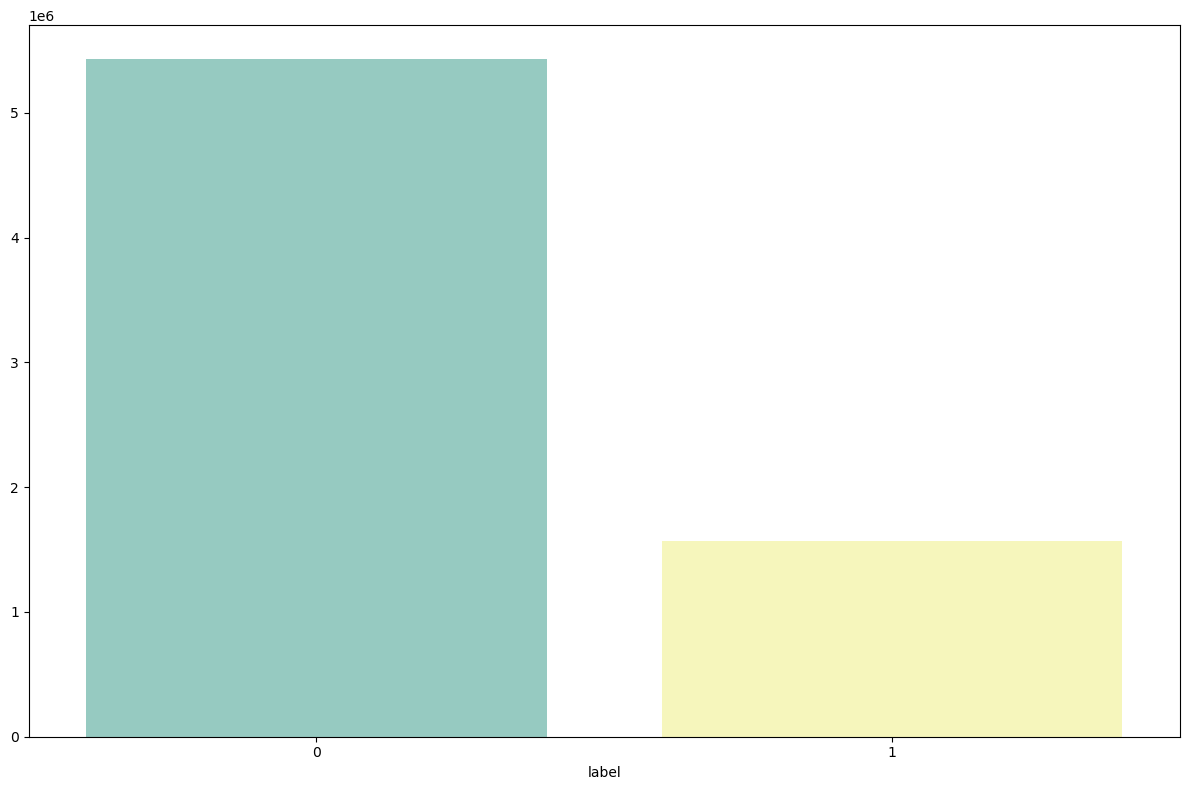

In [8]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = train_df['label'].value_counts().index,
            y = train_df['label'].value_counts().values,
            palette = 'Set3',
            ax = ax)
plt.tight_layout()
plt.show()

In [9]:
train_df[train_df['label'] == 1]

,ID,URL,label
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1
12,TRAIN_0000012,apollo[.]baby,1
...,...,...,...
6995033,TRAIN_6995033,posts-8012419782[.]smarttechno[.]hr,1
6995044,TRAIN_6995044,rthe[.]top/,1
6995047,TRAIN_6995047,www2[.]ml[.]meiceaord[.]com,1
6995050,TRAIN_6995050,10rtggdoffice[.]duckdns[.]org,1


In [10]:
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

In [11]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [12]:
train_df

,ID,URL,label,length,subdomain_count,special_char_count
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,2,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,2,0
2,TRAIN_0000002,nationalfinance.co.om,0,21,1,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,2,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,1,3
...,...,...,...,...,...,...
6995051,TRAIN_6995051,ddht.co.kr,0,10,1,0
6995052,TRAIN_6995052,www.upstartepoxy.com,0,20,1,0
6995053,TRAIN_6995053,employeesalaryschedule70.000webhostapp.com/adb...,1,50,1,2
6995054,TRAIN_6995054,dekalbtool.com,0,14,0,0


In [13]:
test_df['label'] = None

test_df.head()

,ID,URL,length,subdomain_count,special_char_count,label
0,TEST_0000000,niquelarte.blogspot.com.es,26,2,0,None
1,TEST_0000001,northernmetalproducts.com,25,0,0,None
2,TEST_0000002,ga.de,5,0,0,None
3,TEST_0000003,florawww.eeb.uconn.edu/199300089.html,37,3,1,None
4,TEST_0000004,activecity.moscow,17,0,0,None


In [14]:
test_df['label'] is not None

True

In [15]:
test_df = test_df.drop('label', axis = 1)

In [16]:
test_df

,ID,URL,length,subdomain_count,special_char_count
0,TEST_0000000,niquelarte.blogspot.com.es,26,2,0
1,TEST_0000001,northernmetalproducts.com,25,0,0
2,TEST_0000002,ga.de,5,0,0
3,TEST_0000003,florawww.eeb.uconn.edu/199300089.html,37,3,1
4,TEST_0000004,activecity.moscow,17,0,0
...,...,...,...,...,...
1747684,TEST_1747684,culliganlaredo.com,18,0,0
1747685,TEST_1747685,tenzidetailer.pl,16,0,0
1747686,TEST_1747686,club-hippique-neubourg.fr,25,0,2
1747687,TEST_1747687,smbcyt.com/,11,0,1


In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
token_lengths = train_df["URL"].apply(lambda x: len(tokenizer.tokenize(x)))
max_length = int(np.percentile(token_lengths, 95))

class TextDataset(Dataset):
    def __init__(self, df, max_length):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.url = df["URL"].values 
        self.extra_features = df[["length", "subdomain_count", "special_char_count"]].values
        self.label = df.get("label")
        

    def __len__(self):
        return len(self.url)
    
    def __getitem__(self, index):
        url_text = self.df["URL"][index]  # URL 문자열 가져오기
        encoded = self.tokenizer(url_text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        tokenized_url = encoded["input_ids"].squeeze(0)

        if self.label is not None:
            return (tokenized_url,
                    torch.tensor(self.extra_features[index], dtype = torch.float),
                    torch.tensor(self.df.label[index], dtype = torch.long))
        else:
            return (tokenized_url,
                    torch.tensor(self.extra_features[index], dtype = torch.float))

In [18]:
train_df = train_df.drop('ID', axis = 1)
test_df = test_df.drop('ID', axis = 1)



In [19]:
train_df['URL']

0                                         poznan.wuoz.gov.pl
1                                        vill.okawa.kochi.jp
2                                      nationalfinance.co.om
3                                     town.ozora.hokkaido.jp
4                          open24.ie-news.irish/online/Login
                                 ...                        
6995051                                           ddht.co.kr
6995052                                 www.upstartepoxy.com
6995053    employeesalaryschedule70.000webhostapp.com/adb...
6995054                                       dekalbtool.com
6995055                                   helpinganimals.com
Name: URL, Length: 6995056, dtype: object

In [20]:
train_data, val_data = train_test_split(
                                    train_df,
                                    test_size = 0.2, 
                                    random_state = 7
                                )

train_dataset = TextDataset(train_data, max_length)
val_dataset = TextDataset(val_data, max_length)
test_dataset = TextDataset(test_df, max_length)

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)

In [21]:
for tokenized_url, extra_features, label in train_loader:
    print(tokenized_url, extra_features, label)
    break

tensor([[  101,  6925, 26941,  ...,     0,     0,     0],
        [  101,  1039,  4160,  ...,  2100,  2487,   102],
        [  101, 22091,  2050,  ...,     0,     0,     0],
        ...,
        [  101,  1041, 15907,  ...,     0,     0,     0],
        [  101,  2214, 13064,  ...,   102,     0,     0],
        [  101,  1047, 17960,  ...,     0,     0,     0]]) tensor([[ 13.,   0.,   0.],
        [242.,  15.,  22.],
        [  6.,   0.,   0.],
        [ 15.,   0.,   1.],
        [ 13.,   0.,   0.],
        [ 19.,   2.,   0.],
        [  9.,   0.,   0.],
        [ 13.,   0.,   0.],
        [ 92.,   1.,   4.],
        [ 18.,   1.,   0.],
        [ 25.,   1.,   2.],
        [ 10.,   0.,   0.],
        [ 20.,   0.,   0.],
        [ 50.,   1.,   4.],
        [ 20.,   1.,   0.],
        [566.,   0.,  17.],
        [ 20.,   0.,   1.],
        [ 14.,   1.,   1.],
        [ 14.,   0.,   0.],
        [ 15.,   0.,   1.],
        [ 13.,   0.,   0.],
        [ 11.,   0.,   0.],
        [  8.,   0.,  

In [112]:
class URLClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, in_extra, in_out, out_out, dropout_prob, h_ins = [], h_outs = []):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, padding_idx = 0)
        self.in_layer = nn.LayerNorm(embedding_dim, eps = 1e-12)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        
        self.h_layers = nn.ModuleList()
        for idx in range(len(h_ins) - 1):
            self.h_layers.append(nn.Linear(h_ins[idx] + 32, h_outs[idx + 1] + 32))
            self.h_layers.append(nn.LayerNorm(h_outs[idx + 1] + 32, eps = 1e-12))
            self.h_layers.append(nn.GELU())
            self.h_layers.append(nn.Dropout(dropout_prob))

        self.extra_layer = nn.Sequential(
        nn.Linear(in_extra, 32),  # 작은 차원으로 변환
        nn.GELU(),
        nn.Dropout(dropout_prob)
        )

        self.out_layer = nn.Linear(h_outs[-1] + 32 if len(h_outs) else in_out + 32, out_out)

    def forward(self, url_tokens, extra_features):
        url = self.embedding(url_tokens)
        url = self.in_layer(url)
        url = torch.mean(url, dim = 1)
        url = self.dropout(url)

        extra_features = self.extra_layer(extra_features)


        y = torch.cat((url, extra_features), dim = 1)

        for linear in self.h_layers:
            y = linear(y)
        return F.sigmoid(self.out_layer(y))


In [121]:
vocab_size = len(tokenizer.vocab)
embedding_dim = 768
in_extra = 3
in_out = 100 
out_out = 1
h_inouts = [embedding_dim, embedding_dim, embedding_dim, embedding_dim]
dropout = 0.7

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


model = URLClassifier(vocab_size = vocab_size, embedding_dim = embedding_dim, in_extra = 3, in_out = in_out, 
                      out_out = out_out, dropout_prob = dropout,
                      h_ins = h_inouts, h_outs = h_inouts).to(DEVICE)

EPOCH = 300
LR = 0.001

BCEloss = nn.BCELoss()

base_optimizer = optim.Adam(model.parameters(), lr = LR)
optimizer = Lookahead(base_optimizer, k = 5, alpha = 0.5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 10, verbose = True)


In [122]:
model

URLClassifier(
  (embedding): Embedding(30522, 768, padding_idx=0)
  (in_layer): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (gelu): GELU(approximate='none')
  (h_layers): ModuleList(
    (0): Linear(in_features=800, out_features=800, bias=True)
    (1): LayerNorm((800,), eps=1e-12, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=800, out_features=800, bias=True)
    (5): LayerNorm((800,), eps=1e-12, elementwise_affine=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.7, inplace=False)
    (8): Linear(in_features=800, out_features=800, bias=True)
    (9): LayerNorm((800,), eps=1e-12, elementwise_affine=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.7, inplace=False)
  )
  (extra_layer): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.7, inplace=False)


In [123]:
def testing(test_loader):
    model.eval()
    test_loss, test_f1 = 0, 0

    with torch.no_grad():
        for test_url, test_extra_features, test_label in test_loader:
            test_url, test_extra_features, test_label = (test_url.to(DEVICE), test_extra_features.to(DEVICE), test_label.to(DEVICE))
            pre_y = model(test_url, test_extra_features)

            test_label = test_label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, test_label).to(DEVICE)
            test_loss += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, test_label)
            test_f1 += score.item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_f1 = test_f1 / len(test_loader)

    return avg_test_loss, avg_test_f1

In [124]:
SAVE_PATH = './saved_models/'
os.makedirs(SAVE_PATH, exist_ok = True)

def training(train_loader, test_loader):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):

        model.train()

        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_{epoch}.pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_{epoch}.pth')

        loss_total, score_total = 0, 0

        for train_url, train_extra_features, train_label in train_loader:
            train_url, train_extra_features, train_label = (train_url.to(DEVICE), train_extra_features.to(DEVICE), train_label.to(DEVICE))

            pre_y = model(train_url, train_extra_features)
            train_label = train_label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, train_label).to(DEVICE)
            loss_total += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, train_label)
            
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        if epoch % 10 == 0:  # 예시로 10 epoch마다 출력
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f'Epoch {epoch + 1}, Gradient for {name}: {param.grad.abs().mean().item()}')


        test_loss, test_f1 = testing(test_loader)

        LOSS_HISTORY[1].append(test_loss)
        SCORE_HISTORY[1].append(test_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} TRAIN F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- TEST LOSS : {LOSS_HISTORY[1][-1]} TEST F1 : {SCORE_HISTORY[1][-1]}")

        scheduler.step(test_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(model.state_dict(), SAVE_FILE)

        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(model.state_dict(), SAVE_FILE)

        if BREAK_CNT_SCORE > LIMIT_VALUE:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY


In [125]:
loss, f1 = training(train_loader, val_loader)

Epoch 1, Gradient for embedding.weight: 1.239011169218429e-07
Epoch 1, Gradient for in_layer.weight: 0.0004474807938095182
Epoch 1, Gradient for in_layer.bias: 0.0037233238108456135
Epoch 1, Gradient for h_layers.0.weight: 5.213544864091091e-05
Epoch 1, Gradient for h_layers.0.bias: 0.00033925785101018846
Epoch 1, Gradient for h_layers.1.weight: 0.00021993510017637163
Epoch 1, Gradient for h_layers.1.bias: 0.0002694842987693846
Epoch 1, Gradient for h_layers.4.weight: 1.6641839465592057e-05
Epoch 1, Gradient for h_layers.4.bias: 2.919912731158547e-05
Epoch 1, Gradient for h_layers.5.weight: 0.00010714148811530322
Epoch 1, Gradient for h_layers.5.bias: 0.00015728457947261631
Epoch 1, Gradient for h_layers.8.weight: 1.0297160770278424e-05
Epoch 1, Gradient for h_layers.8.bias: 1.2937478459207341e-05
Epoch 1, Gradient for h_layers.9.weight: 0.0001146201029769145
Epoch 1, Gradient for h_layers.9.bias: 0.0002052479685517028
Epoch 1, Gradient for extra_layer.0.weight: 0.006339660845696926
Ep

In [126]:
MODEL_PATH = './saved_models/'

model = URLClassifier(vocab_size = vocab_size, embedding_dim = embedding_dim, in_out = in_out, in_extra = in_extra,
                      out_out = out_out, dropout_prob = dropout,
                      h_ins = h_inouts, h_outs = h_inouts)

model.load_state_dict(torch.load(MODEL_PATH + 'model_weights_25.pth', weights_only = True, map_location = torch.device('cpu')))

<All keys matched successfully>

In [127]:
model.eval()

y_test_preds = []

with torch.no_grad():
    for test_url, test_extra_features in test_loader:
        outputs = model(test_url, test_extra_features).squeeze()
        y_test_preds.extend(outputs.cpu().numpy())

submission_df["probability"] = y_test_preds
submission_df.to_csv(DATA_PATH + "submission_mlp.csv", index=False)

In [120]:
from transformers import AutoModel, AutoTokenizer

model_name = "kmack/malicious-url-detection"
model = AutoModel.from_pretrained(model_name)

print(model)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L